### CSC 578 - Neural Networks and Deep Learning
#### Submitted By: Anuj Verma

## Problem Statement
The task of the competition is to predict the temperature at the next hour given the weather conditions and temperature for prior hours.  This is a multivariate timeseries forecasting problem, and we use a neural network approach to tackle the problem.

This was a kaggle competition and can be found at https://www.kaggle.com/t/2efac42885e94844bf4310454349fcd7

## Dataset
The dataset contains weather conditions recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany, over several years. The dataset for this task is climate_hour.csv. In this dataset, 14 different quantities (including air temperature, atmospheric pressure and humidity) were recorded every 10 minutes. The original data goes back to 2003, but we use a subset for this competition, from 2009 to 2016 (both inclusive). Also for our competition, we use a further reduced version in which recordings are kept for every hour.

**More Task Explaination**
<p>The task should use the data from 1/1/2009 to 12/31/2014 to build a model, and test/predict for 1/1/2015 to 1/1/2017.  And you apply a sliding window of 24 hours, for all features (except for date_time), to predict the temperature of the next hour.  More specifically, you should prepare Keras LSTM-ready datasets to be in the following:

<p>x_train<br>
The first entry should be all variables in the date_time range from 01.01.2009 01:00:00 to 02.01.2009 00:00:00.<br>
The last entry should be all variables in the date_time range from 30.12.2014 23:00:00 to 31.12.2014 22:00:00.
<p>y_train<br>
The first entry should be the temperature of 02.01.2009 01:00:00<br>
The last entry should be the temperature of 31.12.2014 23:00:00
<p>x_test<br>
The first entry should be all variables in the date_time range from 31.12.2014 00:00:00 to 31.12.2014 23:00:00.<br>
The last entry should be all variables in the date_time range from 31.12.2016 00:00:00 to 31.12.2016 23:00:00.

<p>y_test<br>
The first entry should be the temperature of 01.01.2015 00:00:00<br>
The last entry should be the temperature of 01.01.2017 00:00:00

In [1]:
#basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#viz libs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#data processing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#Keras libraries
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,RNN
from keras.layers import Dropout
from keras import regularizers
from keras.layers import Bidirectional
from keras.layers import TimeDistributed

#system libraries and check the files
import os

Using TensorFlow backend.


['climate_hour.csv', 'sample_submission.csv']


In [2]:
data = pd.read_csv('../input/climate_hour.csv')
data.shape

(70037, 15)

In [3]:
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [4]:
#check dtype for date time column
data['Date Time'].dtype

dtype('O')

In [5]:
#get the index for train-test split
data[data['Date Time']=='31.12.2014 22:00:00']

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
52564,31.12.2014 22:00:00,1006.92,1.94,274.56,1.75,98.6,7.03,6.93,0.1,4.29,6.88,1271.74,0.71,1.8,129.6


In [6]:
data[:52565].tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
52560,31.12.2014 18:00:00,1005.71,2.44,275.15,2.16,98.0,7.29,7.14,0.15,4.43,7.10,1267.80,0.77,1.60,152.8
52561,31.12.2014 19:00:00,1006.20,2.27,274.94,1.96,97.8,7.19,7.04,0.16,4.36,6.99,1269.29,0.48,1.28,120.3
52562,31.12.2014 20:00:00,1006.28,2.14,274.81,1.89,98.2,7.13,7.00,0.13,4.34,6.96,1269.97,0.68,1.68,119.3
52563,31.12.2014 21:00:00,1006.69,1.96,274.60,1.72,98.3,7.04,6.92,0.12,4.29,6.87,1271.36,0.67,1.56,145.3
52564,31.12.2014 22:00:00,1006.92,1.94,274.56,1.75,98.6,7.03,6.93,0.10,4.29,6.88,1271.74,0.71,1.80,129.6


In [7]:
np.set_printoptions(suppress=True, precision=2,linewidth=110)
#convert the data in numpy array excluding the Date Time Column
values = data.iloc[:,1:].values
values[:3]

array([[ 996.5 ,   -8.05,  265.38,   -8.78,   94.4 ,    3.33,    3.14,    0.19,    1.96,    3.15, 1307.86,
           0.21,    0.63,  192.7 ],
       [ 996.62,   -8.88,  264.54,   -9.77,   93.2 ,    3.12,    2.9 ,    0.21,    1.81,    2.91, 1312.25,
           0.25,    0.63,  190.3 ],
       [ 996.84,   -8.81,  264.59,   -9.66,   93.5 ,    3.13,    2.93,    0.2 ,    1.83,    2.94, 1312.18,
           0.18,    0.63,  167.2 ]])

## Prepare our data in a format supported by RNNs
Define a Function to create the data in RNN/LSTM suited form. We will need to convert the timeseries data to a supervised dataframe that contains the number of timeframes that we want to refer to predict the future value. The below function does exactly this.

In [8]:
def series_to_supervised(mat,lookback,future_step=1):
    '''
    Convert a timeseries as a supervised learning dataset.
    
    References:
    https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    
    Arguments:
        mat: [np.ndarray] a numpy nd array object with values in float format
        lookback: [int] number of timeframes to look back in past (t-n,...,t-1). This does not include current time frame (t)
                E.g. to look 24 hours data including current time-stamp, this value should be 23 (t-23,..,t-1 and t(covered in future_step)).
        future_step: [int] number of timeframes to look in future (t,t+1,..,t+n). This includes the current time frame (t).
                E.g. to look 1 timeframe ahead in future, the value should be 2 (t and t+1).
        
    Returns:
        A pandas data frame with timeseries framed for supervised learning.
    '''
    
    n_vars = mat.shape[-1]
    df = pd.DataFrame(mat)

    cols,names = list(),list()
    #create input sequence (t-n,....,t-1)
    for i in range(lookback,0,-1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)'%(j+1,i)) for j in range(n_vars)]
    #create forecast sequence (t,t+1,..,t+n)
    for i in range(0,future_step):
        cols.append(df.shift(-i))
        if i==0:
            names+=[('var%d(t)'%(j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)'%(j+1,i)) for j in range(n_vars)]
    #concatenate all columns
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    #drop nulls
    agg.dropna(inplace=True)
    #extract features and target variables and return these
    features = agg.iloc[:,:336]
    target = agg.iloc[:,337]
    return features,target



In [9]:
lookback=23
future_step=2

#prepare the training data in timeseries format

x_train,y_train = series_to_supervised(values[:52564+future_step],23,2)

#prepare the test data in timeseries format
x_test,y_test = series_to_supervised(values[52565-lookback:],lookback,future_step)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(52542, 336)
(52542,)
(17471, 336)
(17471,)


In [10]:
print(x_train.head(3))
print(x_train.tail(3))

    var1(t-23)  var2(t-23)  var3(t-23)    ...     var12(t)  var13(t)  var14(t)
23      996.50       -8.05      265.38    ...         0.41      0.88     155.0
24      996.62       -8.88      264.54    ...         0.28      1.00     148.1
25      996.84       -8.81      264.59    ...         0.49      0.88     209.8

[3 rows x 336 columns]
       var1(t-23)  var2(t-23)    ...     var13(t)  var14(t)
52562     1004.46        1.53    ...         1.68     119.3
52563     1004.23        1.46    ...         1.56     145.3
52564     1004.40        1.47    ...         1.80     129.6

[3 rows x 336 columns]


In [11]:
print(y_train.head(3))
print(y_train.tail(3))

23   -4.44
24   -4.29
25   -4.45
Name: var2(t+1), dtype: float64
52562    1.96
52563    1.94
52564    2.18
Name: var2(t+1), dtype: float64


In [12]:
print(x_test.head(3))
print(x_test.tail(3))

    var1(t-23)  var2(t-23)  var3(t-23)    ...     var12(t)  var13(t)  var14(t)
23     1004.60        1.53      274.33    ...         0.35      0.86     140.8
24     1004.32        1.43      274.25    ...         0.41      0.92     273.8
25     1004.26        1.59      274.41    ...         0.43      0.88     119.1

[3 rows x 336 columns]
       var1(t-23)  var2(t-23)    ...     var13(t)  var14(t)
17491     1008.93       -2.63    ...         1.48    207.50
17492     1008.82       -2.98    ...         0.72      8.15
17493     1008.67       -4.09    ...         1.30    223.70

[3 rows x 336 columns]


In [13]:
print(y_test.head(3))
print(y_test.tail(3))

23    2.06
24    2.22
25    2.04
Name: var2(t+1), dtype: float64
17491   -2.59
17492   -3.76
17493   -4.82
Name: var2(t+1), dtype: float64


** Scale the data**
<br>The features are scaled using ``MinMaxScalar``. Scaling is not performed on target variables, the network is supposed to learn the relationships as this problem is similar to regression.

In [33]:
scalar = MinMaxScaler(feature_range=(0,1))
scalar.fit(x_train)
x_train_scaled = scalar.transform(x_train)
x_test_scaled = scalar.transform(x_test)

In [34]:
print(x_train_scaled[:3])
print(x_test_scaled[:3])

[[0.83 0.25 0.25 ... 0.03 0.04 0.43]
 [0.83 0.24 0.23 ... 0.02 0.05 0.41]
 [0.83 0.24 0.23 ... 0.04 0.04 0.58]]
[[0.91 0.42 0.4  ... 0.03 0.04 0.39]
 [0.91 0.42 0.4  ... 0.03 0.05 0.76]
 [0.91 0.42 0.4  ... 0.03 0.04 0.33]]


In [35]:
#reshape the train and test data
x_train_reshaped= x_train_scaled.reshape(x_train_scaled.shape[0],24,14)
x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0],24,14)

In [36]:
print(x_train_reshaped.shape)
print(x_test_reshaped.shape)
print(y_train.shape)
print(y_test.shape)

(52542, 24, 14)
(17471, 24, 14)
(52542,)
(17471,)


# Defining a Strategy For This Problem
The below steps define the overall strategy for this project. 
1. Create a Trimmed version of data set. This is to facilitate our experimentation with various network architectures and parameters.
2. Create various network architectures and run the model to test the performance.
3. Change various parameters of the networks e.g. batch_size, epochs, activation nodes etc and select the best parameters
4. Split the main training data into train and validation sets to run the models.
5. Select few top model architectures and fit train data from above step and validate the performance with validation set created in above step.
6. Select the best model with optimal parameters (to avoid overfitting) based on above results.
7. Train the best model on whole training data and make the predictions on test data.
8. Create the submission file in the format specified and submit.


## 1. Create Trimmed version of data
The data is sampled randomly from the dataframe. 10000 samples will be extracted and will be split into train and test data to proceed with our experimentations.

In [30]:
sample_size=10000
np.random.seed(10)
rand_idx = np.random.choice(range(len(x_train)),10000)
x_trim = x_train.iloc[rand_idx,:]
y_trim = y_train.iloc[rand_idx]

In [31]:
##create train_test split for the trimmed datset
trainx,testx,trainy,testy = train_test_split(x_trim,y_trim,test_size=0.33,random_state=10)
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(6700, 336)
(3300, 336)
(6700,)
(3300,)


In [37]:
## scale the data using ``MinMaxScalar``
## I will the scalar already fit on the full training data
trainx = scalar.transform(trainx)
testx = scalar.transform(testx)

print(trainx[:2])
print(testx[:2])

[[0.73 0.39 0.4  0.49 0.89 0.09 0.17 0.01 0.17 0.17 0.58 0.18 0.15 0.72 0.74 0.39 0.39 0.48 0.87 0.09 0.17
  0.02 0.16 0.17 0.59 0.12 0.12 0.72 0.74 0.39 0.39 0.48 0.88 0.09 0.17 0.02 0.17 0.17 0.59 0.06 0.06 0.71
  0.75 0.38 0.38 0.48 0.88 0.09 0.16 0.01 0.16 0.16 0.6  0.11 0.11 0.69 0.75 0.38 0.38 0.47 0.88 0.08 0.16
  0.01 0.16 0.16 0.6  0.09 0.08 0.61 0.74 0.38 0.38 0.46 0.82 0.09 0.15 0.02 0.15 0.15 0.6  0.19 0.16 0.6
  0.74 0.4  0.41 0.46 0.73 0.1  0.15 0.04 0.15 0.15 0.58 0.1  0.09 0.61 0.73 0.42 0.42 0.46 0.7  0.1  0.15
  0.04 0.15 0.15 0.56 0.2  0.19 0.56 0.72 0.41 0.42 0.47 0.73 0.1  0.16 0.04 0.16 0.16 0.56 0.2  0.19 0.56
  0.71 0.42 0.43 0.48 0.71 0.11 0.16 0.04 0.16 0.16 0.55 0.47 0.4  0.6  0.7  0.41 0.42 0.47 0.73 0.1  0.16
  0.04 0.16 0.16 0.56 0.31 0.32 0.6  0.69 0.41 0.42 0.46 0.72 0.1  0.15 0.04 0.15 0.15 0.56 0.18 0.15 0.57
  0.69 0.4  0.41 0.45 0.72 0.1  0.15 0.04 0.15 0.15 0.56 0.2  0.2  0.5  0.68 0.4  0.41 0.45 0.73 0.09 0.15
  0.04 0.15 0.15 0.56 0.25 0.22 0.51 0

In [38]:
#reshape the data for LSTM
trainx = trainx.reshape(trainx.shape[0],24,14)
testx = testx.reshape(testx.shape[0],24,14)
trainy = np.array(trainy)
testy=np.array(testy)
print('Reshaped data')
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

Reshaped data
(6700, 24, 14)
(3300, 24, 14)
(6700,)
(3300,)


## 2. Create Various Network Architecture and Test the Performance

Define a function to plot the results of train and test loss. <br>The below function receives the train_loss, validation_loss and number of epochs as a parameter and plots the results.

In [44]:
def plot_results(loss,val_loss,n_epochs):
    epochs = range(1,n_epochs+1)
    plt.subplot(211)
    #plot results
    plt.plot(epochs,loss,'--r',label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Train Loss Plot')
    plt.show()
    plt.subplot(212)
    plt.plot(epochs,val_loss,'--b',label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Test Loss Plot')
    plt.show()


**Design our first network**

In [49]:
epochs = 30
bs = 64

In [47]:
base_model = Sequential()
base_model.add(LSTM(1,input_shape=(24,14),return_sequences=False))
base_model.compile(loss='mae',optimizer='adam')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1)                 64        
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = base_model.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/30
6700/6700 [==============================] - 7s 1ms/step - loss: 10.4432 - val_loss: 10.1524
Epoch 2/30
6700/6700 [==============================] - 6s 929us/step - loss: 10.0425 - val_loss: 9.8641
Epoch 3/30
6700/6700 [==============================] - 6s 918us/step - loss: 9.8581 - val_loss: 9.7398
Epoch 4/30
6700/6700 [==============================] - 6s 934us/step - loss: 9.8012 - val_loss: 9.7354
Epoch 5/30
6700/6700 [==============================] - 6s 922us/step - loss: 9.7999 - val_loss: 9.7348
Epoch 6/30
6700/6700 [==============================] - 6s 934us/step - loss: 9.7993 - val_loss: 9.7341
Epoch 7/30
6700/6700 [==============================] - 6s 941us/step - loss: 9.7986 - val_loss: 9.7335
Epoch 8/30
6700/6700 [==============================] - 6s 933us/step - loss: 9.7980 - val_loss: 9.7328
Epoch 9/30
6700/6700 [==============================] - 6s 952us/step - loss: 9.7973 - val_loss: 9.7321
Epoch 10/30
670

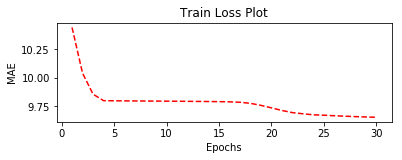

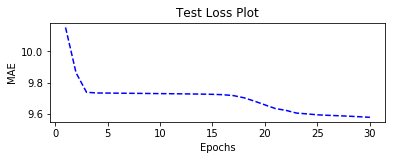

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

It is a decent start. The above graph gives a positive sign. The error is decreasing with the number of epochs which means that our model is learning with each epoch. <br> **This model can serve as a base model.**

**Stacking LSTMs**

In [40]:
model = Sequential()

In [41]:
model.add(LSTM(1,input_shape=(24,14),return_sequences=True,activation = 'relu'))
model.add(LSTM((1),return_sequences=False))
#model.add(Dense(1,activation='softmax'))
model.compile(loss='mae',optimizer='adam')

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 1)             64        
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 12        
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(trainx,trainy,epochs=30,batch_size=64,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/30
6700/6700 [==============================] - 14s 2ms/step - loss: 10.3918 - val_loss: 10.2056
Epoch 2/30
6700/6700 [==============================] - 12s 2ms/step - loss: 10.2324 - val_loss: 10.1101
Epoch 3/30
6700/6700 [==============================] - 12s 2ms/step - loss: 10.1518 - val_loss: 10.0441
Epoch 4/30
6700/6700 [==============================] - 12s 2ms/step - loss: 10.0903 - val_loss: 9.9884
Epoch 5/30
6700/6700 [==============================] - 12s 2ms/step - loss: 10.0277 - val_loss: 9.9020
Epoch 6/30
6700/6700 [==============================] - 12s 2ms/step - loss: 9.8340 - val_loss: 9.7404
Epoch 7/30
6700/6700 [==============================] - 12s 2ms/step - loss: 9.8053 - val_loss: 9.7404
Epoch 8/30
6700/6700 [==============================] - 12s 2ms/step - loss: 9.8053 - val_loss: 9.7404
Epoch 9/30
6700/6700 [==============================] - 12s 2ms/step - loss: 9.8053 - val_loss: 9.7404
Epoch 10/30
6700/

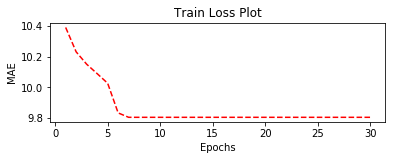

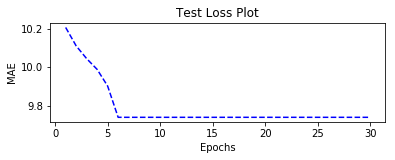

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,30)

In [51]:
epochs = 20
bs = 128
history = model.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/20
6700/6700 [==============================] - 6s 919us/step - loss: 9.8053 - val_loss: 9.7404
Epoch 2/20
6700/6700 [==============================] - 6s 908us/step - loss: 9.8053 - val_loss: 9.7404
Epoch 3/20
6700/6700 [==============================] - 6s 899us/step - loss: 9.8053 - val_loss: 9.7404
Epoch 4/20
6700/6700 [==============================] - 6s 906us/step - loss: 9.8053 - val_loss: 9.7404
Epoch 5/20
6700/6700 [==============================] - 6s 909us/step - loss: 9.8053 - val_loss: 9.7404
Epoch 6/20
6700/6700 [==============================] - 6s 896us/step - loss: 9.8053 - val_loss: 9.7404
Epoch 7/20
6700/6700 [==============================] - 6s 900us/step - loss: 9.8053 - val_loss: 9.7404
Epoch 8/20
6700/6700 [==============================] - 6s 920us/step - loss: 9.8053 - val_loss: 9.7404
Epoch 9/20
6700/6700 [==============================] - 6s 903us/step - loss: 9.8053 - val_loss: 9.7404
Epoch 10/20
6700

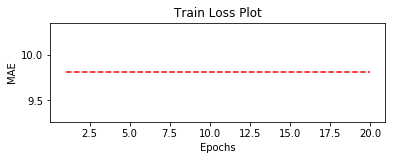

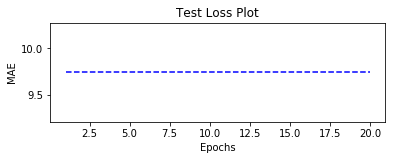

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

I will stick to the batch_size = 64 as it gave me a smooth learning curve for both train and test results.

In [59]:
epochs = 20
bs = 64

In [60]:
m1 = Sequential()
m1.add(LSTM(2,input_shape=(24,14),return_sequences=True,activation = 'relu'))
m1.add(LSTM(1,return_sequences=False))
#m1.add(Dense(1,activation='softmax'))
m1.compile(loss='mae',optimizer='adam')

m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 2)             136       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1)                 16        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = m1.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/20
6700/6700 [==============================] - 14s 2ms/step - loss: 10.4726 - val_loss: 10.3625
Epoch 2/20
6700/6700 [==============================] - 12s 2ms/step - loss: 10.3973 - val_loss: 10.2300
Epoch 3/20
6700/6700 [==============================] - 12s 2ms/step - loss: 10.1345 - val_loss: 9.8438
Epoch 4/20
6700/6700 [==============================] - 12s 2ms/step - loss: 9.8744 - val_loss: 9.7633
Epoch 5/20
6700/6700 [==============================] - 12s 2ms/step - loss: 9.8057 - val_loss: 9.6993
Epoch 6/20
6700/6700 [==============================] - 12s 2ms/step - loss: 9.7445 - val_loss: 9.6396
Epoch 7/20
6700/6700 [==============================] - 12s 2ms/step - loss: 9.6849 - val_loss: 9.5867
Epoch 8/20
6700/6700 [==============================] - 12s 2ms/step - loss: 9.6436 - val_loss: 9.5664
Epoch 9/20
6700/6700 [==============================] - 12s 2ms/step - loss: 9.6368 - val_loss: 9.5644
Epoch 10/20
6700/670

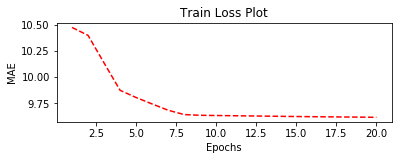

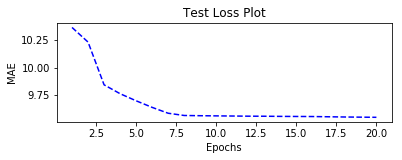

In [62]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

**Stack 3 LSTMs with 100 activation nodes each, 2 Dense Layers. Use Dropout to avoid overfitting the network**

In [63]:
#Stack more LSTM layers with 100 activation nodes and two Dense layers. Use Dropout to avoid overfitting the network.
m2 = Sequential()
m2.add(LSTM(100,input_shape=(24,14),return_sequences=True,activation = 'relu'))
m2.add(LSTM(100,return_sequences=True,activation='relu'))
m2.add(LSTM(100,return_sequences=False,activation='relu'))
m2.add(keras.layers.Dropout(0.25))
m2.add(Dense(100,activation='relu'))
m2.add(keras.layers.Dropout(0.25))
m2.add(Dense(1))
m2.compile(loss='mae',optimizer='adam')

m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 24, 100)           46000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 100)           80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total para

In [64]:
history = m2.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/20
6700/6700 [==============================] - 23s 3ms/step - loss: 6.6892 - val_loss: 3.8032
Epoch 2/20
6700/6700 [==============================] - 20s 3ms/step - loss: 3.3276 - val_loss: 2.5996
Epoch 3/20
6700/6700 [==============================] - 20s 3ms/step - loss: 2.8626 - val_loss: 2.4523
Epoch 4/20
6700/6700 [==============================] - 20s 3ms/step - loss: 2.7439 - val_loss: 2.4556
Epoch 5/20
6700/6700 [==============================] - 20s 3ms/step - loss: 2.5704 - val_loss: 2.1239
Epoch 6/20
6700/6700 [==============================] - 20s 3ms/step - loss: 2.4799 - val_loss: 2.0734
Epoch 7/20
6700/6700 [==============================] - 20s 3ms/step - loss: 2.4804 - val_loss: 1.9029
Epoch 8/20
6700/6700 [==============================] - 20s 3ms/step - loss: 2.2541 - val_loss: 1.5786
Epoch 9/20
6700/6700 [==============================] - 20s 3ms/step - loss: 1.9241 - val_loss: 1.4425
Epoch 10/20
6700/6700 [==

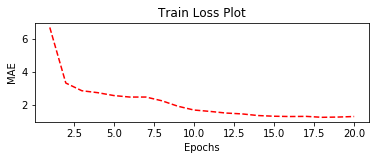

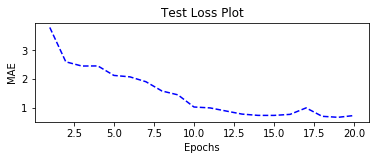

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

The error has come down significantly for both train and validation set. This could be because of either increased number of activation nodes in LSTM or because of including multiple dense layers. <br>Let us observe next, the effect of increasing just the activations of LSTM keeping the Dense layer to 1.

In [68]:
#Stack LSTM with default activation function
m3 = Sequential()
m3.add(LSTM(50,return_sequences=True,input_shape = (24,14)))
m3.add(LSTM(50,return_sequences=False))
m3.add(Dense(1))

m3.compile(loss='mae',optimizer='adam')

m3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 24, 50)            13000     
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 33,251
Trainable params: 33,251
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = m3.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/20
6700/6700 [==============================] - 15s 2ms/step - loss: 7.4334 - val_loss: 6.8985
Epoch 2/20
6700/6700 [==============================] - 13s 2ms/step - loss: 6.4374 - val_loss: 4.6993
Epoch 3/20
6700/6700 [==============================] - 13s 2ms/step - loss: 3.6608 - val_loss: 2.8978
Epoch 4/20
6700/6700 [==============================] - 13s 2ms/step - loss: 2.7871 - val_loss: 2.4327
Epoch 5/20
6700/6700 [==============================] - 13s 2ms/step - loss: 2.0634 - val_loss: 1.6072
Epoch 6/20
6700/6700 [==============================] - 13s 2ms/step - loss: 1.4063 - val_loss: 1.1971
Epoch 7/20
6700/6700 [==============================] - 13s 2ms/step - loss: 1.1146 - val_loss: 0.9742
Epoch 8/20
6700/6700 [==============================] - 13s 2ms/step - loss: 0.9061 - val_loss: 0.8536
Epoch 9/20
6700/6700 [==============================] - 13s 2ms/step - loss: 0.7870 - val_loss: 0.7591
Epoch 10/20
6700/6700 [==

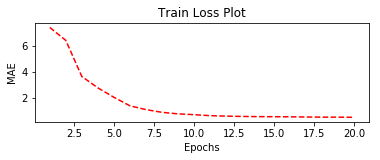

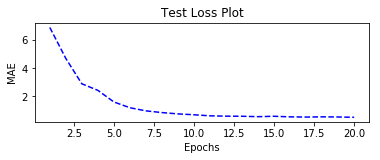

In [70]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

The above model gave good results. The train and validation error has come under 1, which is a really good performance. The error still seems to be decreasing. We can perhaps achieve even better results by increasing the number of epochs for this network architecture. However, for our experimentation, I will stop here and experiment with other architectures first.

Now, I want to experiment with stacking 3 LSTM layers on top of 2 dense layers with 25% dropout. Essentially, This network is similar to the m2 network trained above. However, I am using 50 activations for LSTM layers and using the default activation function ``hard_sigmoid`` and not ``relu``

In [77]:
m5 = Sequential()
m5.add(LSTM(50,return_sequences=True,input_shape = (24,14)))
m5.add(LSTM(50,return_sequences=True))
m5.add(LSTM(50,return_sequences=False))
m5.add(Dropout(0.25))
m5.add(Dense(100))
m5.add(Dropout(0.25))
m5.add(Dense(1))

m5.compile(loss='mae',optimizer='adam')
m5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 24, 50)            13000     
_________________________________________________________________
lstm_20 (LSTM)               (None, 24, 50)            20200     
_________________________________________________________________
lstm_21 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total para

In [78]:
history = m5.fit(trainx,trainy,epochs=20,batch_size=64,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/20
6700/6700 [==============================] - 23s 3ms/step - loss: 5.3631 - val_loss: 3.0409
Epoch 2/20
6700/6700 [==============================] - 20s 3ms/step - loss: 3.0748 - val_loss: 2.4808
Epoch 3/20
6700/6700 [==============================] - 20s 3ms/step - loss: 2.2747 - val_loss: 1.6461
Epoch 4/20
6700/6700 [==============================] - 19s 3ms/step - loss: 1.7518 - val_loss: 1.1768
Epoch 5/20
6700/6700 [==============================] - 20s 3ms/step - loss: 1.4871 - val_loss: 0.9829
Epoch 6/20
6700/6700 [==============================] - 20s 3ms/step - loss: 1.2795 - val_loss: 1.0011
Epoch 7/20
6700/6700 [==============================] - 20s 3ms/step - loss: 1.2494 - val_loss: 0.7054
Epoch 8/20
6700/6700 [==============================] - 20s 3ms/step - loss: 1.1688 - val_loss: 0.6984
Epoch 9/20
6700/6700 [==============================] - 20s 3ms/step - loss: 1.1652 - val_loss: 0.7655
Epoch 10/20
6700/6700 [==

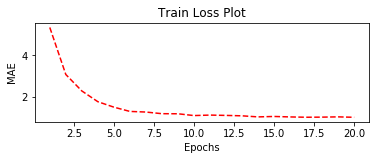

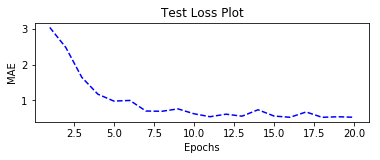

In [79]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

I can see improved results from the similar model m2 trained above. This improvement was because of non-inclusion of activation function within the layers of the network.

### Bidirectional LSTMs with Dense layer

In [74]:
## One Bidirectional LSTM with LSTM and Dense layer
m4 = Sequential()
m4.add(Bidirectional(LSTM(50,return_sequences=True,input_shape = (24,14))))
m4.add(LSTM(50,return_sequences=False))
m4.add(Dense(1))
m4.compile(loss='mae',optimizer='adam')

#m4.summary()

In [75]:
history = m4.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/20
6700/6700 [==============================] - 22s 3ms/step - loss: 5.7785 - val_loss: 3.0951
Epoch 2/20
6700/6700 [==============================] - 19s 3ms/step - loss: 2.3888 - val_loss: 1.9283
Epoch 3/20
6700/6700 [==============================] - 19s 3ms/step - loss: 1.6617 - val_loss: 1.4721
Epoch 4/20
6700/6700 [==============================] - 19s 3ms/step - loss: 1.2563 - val_loss: 1.0926
Epoch 5/20
6700/6700 [==============================] - 19s 3ms/step - loss: 1.0775 - val_loss: 1.0396
Epoch 6/20
6700/6700 [==============================] - 19s 3ms/step - loss: 0.9772 - val_loss: 0.8807
Epoch 7/20
6700/6700 [==============================] - 19s 3ms/step - loss: 0.9040 - val_loss: 0.8424
Epoch 8/20
6700/6700 [==============================] - 19s 3ms/step - loss: 0.8319 - val_loss: 0.8157
Epoch 9/20
6700/6700 [==============================] - 19s 3ms/step - loss: 0.7997 - val_loss: 0.7518
Epoch 10/20
6700/6700 [==

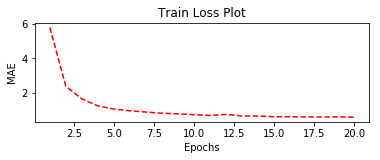

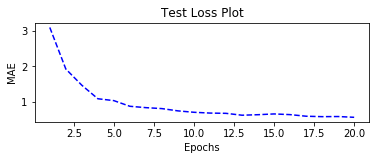

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

The above nework also gave good results on the train and validation data. Also, these results seems to be improving with increasing number of epochs. However, I will pass the epochs once again to test for other architectures.

In [80]:
#Two bidirectional LSTMs, One LSTM, Two Dense layers stacked together with 25% Dropout to control overfitting
m6 = Sequential()
m6.add(Bidirectional(LSTM(100,return_sequences=True,input_shape = (24,14))))
m6.add(Bidirectional(LSTM(50,return_sequences=True)))
m6.add(LSTM(50,return_sequences=False))
m6.add(Dropout(0.25))
m6.add(Dense(100))
m6.add(Dropout(0.25))
m6.add(Dense(1))

m6.compile(loss='mae',optimizer='adam')

#m6.summary()

In [81]:
history = m6.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/20
6700/6700 [==============================] - 38s 6ms/step - loss: 5.3221 - val_loss: 2.0144
Epoch 2/20
6700/6700 [==============================] - 31s 5ms/step - loss: 1.9077 - val_loss: 1.3021
Epoch 3/20
6700/6700 [==============================] - 31s 5ms/step - loss: 1.5949 - val_loss: 1.0393
Epoch 4/20
6700/6700 [==============================] - 31s 5ms/step - loss: 1.4143 - val_loss: 0.9177
Epoch 5/20
6700/6700 [==============================] - 31s 5ms/step - loss: 1.3908 - val_loss: 1.0088
Epoch 6/20
6700/6700 [==============================] - 31s 5ms/step - loss: 1.2888 - val_loss: 0.7282
Epoch 7/20
6700/6700 [==============================] - 31s 5ms/step - loss: 1.2267 - val_loss: 0.8404
Epoch 8/20
6700/6700 [==============================] - 31s 5ms/step - loss: 1.2210 - val_loss: 0.8581
Epoch 9/20
6700/6700 [==============================] - 31s 5ms/step - loss: 1.1739 - val_loss: 0.7119
Epoch 10/20
6700/6700 [==

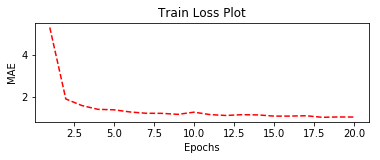

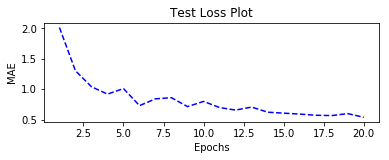

In [82]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

### Select Promising Models from above experiments:

I will pick 3 models from above experiments based on the promise of performance from the empirical results shown in the graphs. These models are:
- m3
- m4
- m6

*models summarized in below cells*

Let us try to explore these models further by changing the parameters and see if the performance further improves.

In [83]:
m3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 24, 50)            13000     
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 33,251
Trainable params: 33,251
Non-trainable params: 0
_________________________________________________________________


In [84]:
m4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 24, 100)           26000     
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 56,251
Trainable params: 56,251
Non-trainable params: 0
_________________________________________________________________


In [85]:
m6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 24, 200)           92000     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 24, 100)           100400    
_________________________________________________________________
lstm_24 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               5100      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total para

**Disclaimer:** The Best way to check for best parameters is probably to do a GridSearch. However, that will require a lot of training time. To save some time in this competition, I will try to run as many models as I can with above parameters and select one best among these with best suited parameters. 
<br>In future, I can do a gridsearch over above parameters lists (or even more params) and select the best model.


In [113]:
#params
bs = 32
epochs = 20

In [108]:
sgd = keras.optimizers.SGD(lr = 0.01,momentum=0.9,decay = 0.0001)
adam = keras.optimizers.Adam(lr = 0.001,decay=0.001)

In [109]:
m3.compile(loss = 'mae',optimizer=adam)
history = m3.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/30
6700/6700 [==============================] - 30s 5ms/step - loss: 0.4783 - val_loss: 0.4765
Epoch 2/30
6700/6700 [==============================] - 26s 4ms/step - loss: 0.4664 - val_loss: 0.4718
Epoch 3/30
6700/6700 [==============================] - 26s 4ms/step - loss: 0.4628 - val_loss: 0.4731
Epoch 4/30
6700/6700 [==============================] - 26s 4ms/step - loss: 0.4597 - val_loss: 0.4686
Epoch 5/30
6700/6700 [==============================] - 26s 4ms/step - loss: 0.4572 - val_loss: 0.4676
Epoch 6/30
6700/6700 [==============================] - 26s 4ms/step - loss: 0.4551 - val_loss: 0.4676
Epoch 7/30
6700/6700 [==============================] - 26s 4ms/step - loss: 0.4535 - val_loss: 0.4672
Epoch 8/30
6700/6700 [==============================] - 26s 4ms/step - loss: 0.4525 - val_loss: 0.4660
Epoch 9/30
6700/6700 [==============================] - 26s 4ms/step - loss: 0.4513 - val_loss: 0.4663
Epoch 10/30
6700/6700 [==

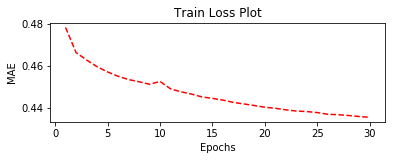

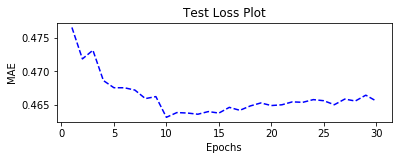

In [112]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

In [114]:
m4.compile(loss = 'mae',optimizer=adam)
history = m4.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/20
6700/6700 [==============================] - 43s 6ms/step - loss: 0.5493 - val_loss: 0.5072
Epoch 2/20
6700/6700 [==============================] - 38s 6ms/step - loss: 0.5110 - val_loss: 0.4929
Epoch 3/20
6700/6700 [==============================] - 38s 6ms/step - loss: 0.5041 - val_loss: 0.4910
Epoch 4/20
6700/6700 [==============================] - 38s 6ms/step - loss: 0.4978 - val_loss: 0.4856
Epoch 5/20
6700/6700 [==============================] - 38s 6ms/step - loss: 0.4970 - val_loss: 0.4874
Epoch 6/20
6700/6700 [==============================] - 38s 6ms/step - loss: 0.4946 - val_loss: 0.4826
Epoch 7/20
6700/6700 [==============================] - 38s 6ms/step - loss: 0.4924 - val_loss: 0.4816
Epoch 8/20
6700/6700 [==============================] - 38s 6ms/step - loss: 0.4915 - val_loss: 0.4841
Epoch 9/20
6700/6700 [==============================] - 38s 6ms/step - loss: 0.4907 - val_loss: 0.4809
Epoch 10/20
6700/6700 [==

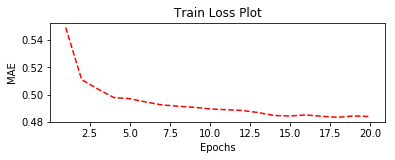

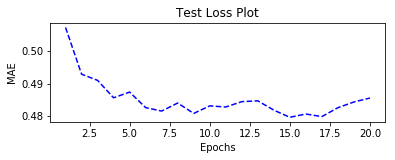

In [115]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

In [120]:
m6 = Sequential()
m6.add(Bidirectional(LSTM(100,return_sequences=True,input_shape = (24,14))))
m6.add(Bidirectional(LSTM(50,return_sequences=True)))
m6.add(LSTM(50,return_sequences=False))
m6.add(Dropout(0.25))
m6.add(Dense(100,kernel_regularizer=regularizers.l2(0.01)))
m6.add(Dropout(0.25))
m6.add(Dense(1))

m6.compile(loss='mae',optimizer=adam)
history = m6.fit(trainx,trainy,epochs=30,batch_size=bs,validation_data=(testx,testy),shuffle=False)

Train on 6700 samples, validate on 3300 samples
Epoch 1/30
6700/6700 [==============================] - 72s 11ms/step - loss: 5.5688 - val_loss: 2.9905
Epoch 2/30
6700/6700 [==============================] - 63s 9ms/step - loss: 3.0558 - val_loss: 2.4632
Epoch 3/30
6700/6700 [==============================] - 62s 9ms/step - loss: 2.6217 - val_loss: 2.1995
Epoch 4/30
6700/6700 [==============================] - 62s 9ms/step - loss: 2.4306 - val_loss: 2.1028
Epoch 5/30
6700/6700 [==============================] - 62s 9ms/step - loss: 2.2798 - val_loss: 1.8453
Epoch 6/30
6700/6700 [==============================] - 62s 9ms/step - loss: 2.1681 - val_loss: 1.6607
Epoch 7/30
6700/6700 [==============================] - 62s 9ms/step - loss: 2.0684 - val_loss: 1.5702
Epoch 8/30
6700/6700 [==============================] - 62s 9ms/step - loss: 1.9837 - val_loss: 1.7031
Epoch 9/30
6700/6700 [==============================] - 62s 9ms/step - loss: 1.9471 - val_loss: 1.4583
Epoch 10/30
6700/6700 [=

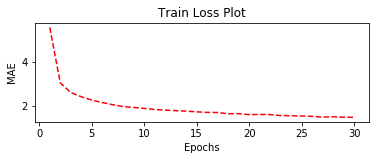

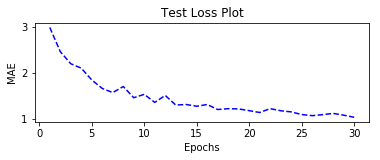

In [122]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,30)

The above 3 models have improved in there results from previous run. Based on the different experiments on the parameters, I came up with below parameter values to use:<br>
``batch_size=32``,``optimizer=adam(lr=0.001,decay=0.001)``, ``epochs`` anywhere between 10-30.

We are now ready to use these models on train data and predict the results.

## 4. Split the main training data into train and validation sets to run the models.

In [123]:
##create train_test split for the original train set
trainx,testx,trainy,testy = train_test_split(x_train,y_train,test_size=0.33,random_state=10)
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(35203, 336)
(17339, 336)
(35203,)
(17339,)


In [127]:
## scale the data using ``MinMaxScalar``
## I will the scalar already fit on the full training data
scaler = MinMaxScaler()
scaler.fit(trainx)
trainx = scaler.transform(trainx)
testx = scaler.transform(testx)

In [128]:
#reshape the data for LSTM
trainx = trainx.reshape(trainx.shape[0],24,14)
testx = testx.reshape(testx.shape[0],24,14)
trainy = np.array(trainy)
testy=np.array(testy)
print('Reshaped data')
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

Reshaped data
(35203, 24, 14)
(17339, 24, 14)
(35203,)
(17339,)


## 5. Select top 3 model architectures, fit train data and check performance on validation data (created above)
    Note that this step does not use the original test data. That data will only be used to make final predictions.

In [130]:
#Stack LSTM with default activation function
m3a = Sequential()
m3a.add(LSTM(50,return_sequences=True,input_shape = (24,14)))
m3a.add(LSTM(50,return_sequences=False))
m3a.add(Dense(1))

## One Bidirectional LSTM with LSTM and Dense layer
m4a = Sequential()
m4a.add(Bidirectional(LSTM(50,return_sequences=True),input_shape = (24,14)))
m4a.add(LSTM(50,return_sequences=False))
m4a.add(Dense(1))

#Two bidirectional LSTMs, One LSTM, Two Dense layers stacked together with 25% Dropout to control overfitting
m6a = Sequential()
m6a.add(Bidirectional(LSTM(100,return_sequences=True),input_shape = (24,14)))
m6a.add(Bidirectional(LSTM(50,return_sequences=True)))
m6a.add(LSTM(50,return_sequences=False))
m6a.add(Dropout(0.25))
m6a.add(Dense(100,kernel_regularizer=regularizers.l2(0.01)))
m6a.add(Dropout(0.25))
m6a.add(Dense(1))

In [131]:
#best parameters for training
adam = keras.optimizers.Adam(lr = 0.001,decay=0.001)
epochs = 50
bs=32

In [132]:
#compile the models
m3a.compile(loss='mae',optimizer=adam)
m4a.compile(loss='mae',optimizer=adam)
m6a.compile(loss='mae',optimizer=adam)

In [ ]:
m3a.summary()

In [ ]:
m4a.summary()

In [ ]:
m6a.summary()

In [ ]:
history = m3a.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

In [ ]:

history = m4a.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

In [ ]:
epochs=100
history = m6a.fit(trainx,trainy,epochs=epochs,batch_size=bs,validation_data=(testx,testy),shuffle=False)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(loss,val_loss,epochs)

## 6. Select the best model with optimal parameters (to avoid overfitting)
    The Decision is based on above results

## 7. Fit Final model on whole training data and make Predictions

In [ ]:
## scale the data using ``MinMaxScalar``
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

## reshape the features for LSTM
x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0],24,14)
x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0],24,14)
y_train = np.array(trainy)
y_test=np.array(testy)
print('Reshaped data')
print(x_train_reshaped.shape)
print(x_test_reshaped.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
x_test_scaled = scaler.transform(x_test)
x_test_reshaped=x_test_scaled.reshape(x_test_scaled.shape[0],24,14)
print(x_test_reshaped.shape)

In [ ]:
epochs = 50
bs = 32
history = m3a.fit(x_train_reshaped,y_train,epochs=epochs,batch_size=bs,validation_data=None,shuffle=False)

In [ ]:
pred = m3a.predict(x_test_reshaped)

In [ ]:
mean_absolute_error(np.ravel(y_test),pred)

## 8. Create the submission file in the format specified and submit.

In [ ]:
sample = pd.read_csv('../input/sample_submission.csv')
df_submit = pd.DataFrame(data = pred)
df_submit.insert(0,'date_time',sample.iloc[:,0])
df_submit.columns=['date_time','temperature']
df_submit.head()

In [ ]:
df_submit.to_csv('temp_pred_submission.csv',index=False,sep=',',header=True)